Original Opensees Example Link: https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_4._Portal_Frame

<img src="https://opensees.berkeley.edu/wiki/images/e/e0/Example4_figure1.GIF" align="left"></img>
<img src="https://opensees.berkeley.edu/wiki/images/5/59/Example1b_Push.GIF" align="right"></img>

In [1]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt
import math

## Units Conversion

In [2]:
#length conversion
m = 1.0
cm = 100*m # centimeter, needed for displacement input in MultipleSupport excitation
inch = m/39.37
ft = 12.*inch 

#area conversion
sqinch = inch**2
inch4 = inch**4

#ksi to pa
pa = 1.0
kpa = 1000*pa
ksi = 6.89*1000*kpa  #ksi = kip / sqinch
psi = ksi/1000.


#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN

# pound to kg
kg = 1 
pound = 0.453592 * kg
lbf = psi*inch**2  #pounds force
pcf = lbf/math.pow(ft, 3) #pounds per cubic foot
psf = lbf/math.pow(ft, 2) #pounds per square foot


# acceleration due to gravity
g = 9.81 #m/s^2

#time
sec = 1.0


## Model Varibles for Elastic Element Section

In [3]:
#refrences taken from elastic model in original example 
sectionType = 'elastic'  #this analysis uses elastic section of beam and column

#Structure Geometry
LCol = 36.*ft		# column length
LBeam = 42.*ft		# beam length
Weight = 4000.*kip		# superstructure weight #total imposed load on the beam in kN or Kip


#section general geometry
HCol = 5.*ft #depth of column
BCol = 4.*ft #width of column
HBeam = 8.*ft #depth of beam
BBeam = 5.*ft #width of beam

# calculated parameters
PCol = Weight/2 #nodal dead weight per column
Mass = PCol/g #nodal mass
MCol = 1./12.* (Weight/LBeam) *math.pow(LBeam,2)	# beam-end moment due to distributed load.        #wl^2/12


#calculated geometry parameters
ACol = BCol * HCol
ABeam = BBeam * HBeam
IzCol = 1./12. * BCol * math.pow(HCol, 3)
IzBeam = 1./12. * BBeam * math.pow(HBeam, 3)

## Model Functions

In [4]:
def getModel():
    ops.wipe()
    ops.model("BasicBuilder", '-ndm', 2, '-ndf', 3)

    #nodes definition
    xcor = [0, LBeam]
    ycor = [0, LCol]
    for j,y in enumerate(ycor):
        for i,x in enumerate(xcor):
            ops.node(j*len(xcor)+i + 1, *[x,y])
    
    #fixity definition
    ops.fixY(0, *[1,1,1]) #fix all nodes with ycoordinate = 0 (so fixing both node 1 and 2: base nodes)

    # nodal masses:
    ops.mass(3, *[Mass, 0., 0.])	# node#, Mx My Mz, Mass=Weight/g, neglect rotational inertia at nodes
    ops.mass(4, *[Mass, 0., 0.])
    

In [5]:
def getSections(plotFiber = True):
    #section tags identifiers
    colSecTag = 1
    beamSecTag = 2
    
    #section Geometry
    coverCol = 6.*inch		# Column cover to reinforcing steel NA.
    numBarsCol = 10	# number of longitudinal-reinforcement bars in each side of column section. (symmetric top & bot)
    barAreaCol = 2.25*sqinch	# area of longitudinal-reinforcement bars

    # MATERIAL parameters -------------------------------------------------------------------
    IDconcU = 1 			# material ID tag -- unconfined cover concrete
    IDreinf = 2 				# material ID tag -- reinforcement
    
    #material properties
    fc = -4. * ksi # CONCRETE Compressive Strength (+Tension, -Compression)
    Ec = 57 * ksi * math.sqrt(-fc/psi) # Concrete Elastic Modulus

    # unconfined concrete
    fc1U = fc		# UNCONFINED concrete (todeschini parabolic model), maximum stress
    eps1U = -0.003		# strain at maximum strength of unconfined concrete
    fc2U = 0.2*fc1U		# ultimate stress
    eps2U = -0.05;			# strain at ultimate stress
    lambda_ = 0.1;				# ratio between unloading slope at $eps2 and initial slope $Ec

    # tensile-strength properties
    ftU = -0.14*fc1U		# tensile strength +tension
    Ets = ftU/0.002		# tension softening stiffness
    # -----------
    Fy = 66.8*ksi		# STEEL yield stress
    Es = 29000.*ksi	# modulus of steel
    Bs = 0.01			# strain-hardening ratio 
    R0 = 18				# control the transition from elastic to plastic branches
    cR1=  0.925			# control the transition from elastic to plastic branches
    cR2=  0.15				# control the transition from elastic to plastic branches

    ops.uniaxialMaterial('Concrete02', IDconcU, fc1U, eps1U, fc2U, eps2U, lambda_, ftU, Ets)	# build cover concrete (unconfined)
    ops.uniaxialMaterial('Steel02', IDreinf, Fy, Es, Bs, R0, cR1, cR2)			# build reinforcement material

    #section properties
    #Column Section
    coverY = HCol/2.0	# The distance from the section z-axis to the edge of the cover concrete -- outer edge of cover concrete
    coverZ = BCol/2.0	# The distance from the section y-axis to the edge of the cover concrete -- outer edge of cover concrete
    coreY = coverY-coverCol
    coreZ = coverZ-coverCol
    nfY = 16			# number of fibers for concrete in y-direction
    nfZ = 4 	# number of fibers for concrete in z-direction

    ops.section('Fiber', colSecTag)	# Define the fiber section
    ops.patch('quadr', IDconcU, nfZ, nfY, *[-coverY, coverZ, -coverY, -coverZ, coverY, -coverZ, coverY, coverZ]) 	# Define the concrete patch
    ops.layer('straight', IDreinf, numBarsCol, barAreaCol, *[-coreY, coreZ, -coreY, -coreZ])	# top layer reinfocement
    ops.layer('straight', IDreinf, numBarsCol, barAreaCol, *[coreY, coreZ,  coreY, -coreZ])	# bottom layer reinforcement
    # end of fibersection definition

    #Beam Section - Elastic
    ops.section('Elastic', beamSecTag, Ec, ABeam, IzBeam)

    #elements
    colTransfTag = 1
    beamTransfTag = 2
    colTransfType = 'Linear'  #making this variable to help easy change of linear to pdelta, as only column have pdelta effects
    ops.geomTransf(colTransfType, colTransfTag)
    ops.geomTransf('Linear', beamTransfTag)

    
    #element define
    #element('nonlinearBeamColumn', eleTag, *eleNodes, numIntgrPts, secTag, transfTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0, '-integration', intType)
    numIntgrPts = 5

    ops.element('nonlinearBeamColumn', 1, *[1,3], numIntgrPts, colSecTag, colTransfTag)
    ops.element('nonlinearBeamColumn', 2, *[2,4], numIntgrPts, colSecTag, colTransfTag)
    ops.element('nonlinearBeamColumn', 3, *[3,4], numIntgrPts, beamSecTag, beamTransfTag)

    if plotFiber:
        fibSecList = [['section', 'Fiber', colSecTag],	# Define the fiber section
        ['patch', 'quadr', IDconcU, nfZ, nfY, *[-coverY, coverZ, -coverY, -coverZ, coverY, -coverZ, coverY, coverZ]],	# Define the concrete patch
        ['layer', 'straight', IDreinf, numBarsCol, barAreaCol, *[-coreY, coreZ, -coreY, -coreZ]],	# top layer reinfocement
        ['layer', 'straight', IDreinf, numBarsCol, barAreaCol, *[coreY, coreZ,  coreY, -coreZ]]# bottom layer reinforcement
                     ]
        matcolor = ['lightgrey', 'lightgrey', 'gold', 'w', 'w', 'w']
        ovs.plot_fiber_section(fibSecList ,matcolor=matcolor)
        plt.axis('equal')
        plt.title("Fiber Section of Column")

## Recorder Functions

In [6]:
def getRecorders(SectionType, AnalyisName):
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}/DispFree.txt", 
                 '-time', '-closeOnWrite', '-node', *[3,4],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}/DispSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}/ReactionsSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'reaction')

    #drift recorder: but throws error in openseespy
    #ops.recorder("drift", '-file', f"Outputs/{SectionType}/{AnalyisName}_Drift.txt", '-time', '-closeOnWrite', '-inode', *[1,2],'-jnode', *[3,4], '-dof', 1, '-perpDirn', 2)
    
    #recorder Element -file Data/FCol.out -time -ele 1 force
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}/ForcesColumn.txt', 
                 '-time', '-closeOnWrite', '-ele', *[1,2], 'globalForce')
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}/ForcesBeam.txt', 
                 '-time', '-closeOnWrite', '-ele', 3, 'globalForce')				# Column section forces, axial and moment, node i


## Analysis Functions

In [7]:
linTS = 1 #linear time series tag
sineSeries = 2 #uniform excitation tag

### Gravity Analysis

In [8]:
## Analysis Definitions
def runGravityAnalysis():
    udlBeam = Weight/LBeam
    #gravity loads

    ops.timeSeries('Linear', linTS)
    ops.pattern('Plain', 100, linTS) #patterntype #patterntag #timeseries tag
    ops.eleLoad('-ele', 3, '-type', '-beamUniform', -1* udlBeam)


    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    
    tol = 1.0e-8
    numIter = 6
    ops.test('NormDispIncr', tol, numIter) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm('Newton')

    NStepGravity = 10
    DGravity = 1.0 / NStepGravity
    ops.integrator('LoadControl', DGravity)
    ops.analysis('Static')

    ops.record() #to force recorder to record initial state of the model regarding gravity loads
    ops.analyze(NStepGravity)

    #since static pushover is performed after gravity analysis--- set gravity load constant and time to 0
    ops.loadConst('-time', 0.)

### Static Pushover

In [9]:
def runStaticPushover():
    #since static pushover is performed after gravity analysis--- set gravity load constant and time to 0
    ops.loadConst('-time', 0)
    
    #structure parameters
    ControlNode = 3
    ControlNodeDof = 1
    
    #analysis parameters
    Dmax = .1*LCol # maximum displacement of pushover. push to 10% drift.
    Dincr = 0.001*LCol  #increment in displacement for pushover
    NStepPushover = int(Dmax/Dincr)
    
    #incase we want to change test type due to convergence failure
    testTypeStatic = 'EnergyIncr'
    algorithmTypeStatic = 'Newton'
    
    tolStatic = 1.0e-11  
    maxNumIterStatic = 100
    maxNumIterConvergeStatic = 2000 # for improved-convergence procedure
    
    # define the lateral load as a proportion of the weight so that the pseudo time equals the lateral-load coefficient when using linear load pattern
    Hload = Weight/2
    ops.pattern('Plain', 200, linTS) #patterntype #patterntag #timeseries tag
    ops.load(3, *[Hload, 0., 0.])
    ops.load(4, *[Hload, 0., 0.])
    
    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('RCM')
    ops.system('BandGeneral')
    
    ops.test(testTypeStatic, tolStatic, maxNumIterStatic) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm(algorithmTypeStatic)
    
    ops.integrator('DisplacementControl', ControlNode, ControlNodeDof, Dincr)
    ops.analysis('Static')

    ops.record() #to force recorder to record initial state of the model regarding gravity loads
    i = 0
    while ops.nodeDisp(ControlNode, ControlNodeDof) < Dmax:
        status = ops.analyze(1)
        i += 1
        #handling well if the analysis fails:
        if status != 0:
            print("Analysis failed at load factor ", i)
            if status != 0:
                print("Trying Newton with Initial Tangent at Load Factor", i)
                ops.test('NormDispIncr', tolStatic, 2000)
                ops.algorithm('Newton', '-initial')
                status = ops.analyze(1)
                ops.test(testTypeStatic, tolStatic, maxNumIterStatic)
                
            if status !=0:
                print("Trying Bryoden at Load Factor", i)
                ops.algorithm('Bryoden', 8)
                status = ops.analyze(1)
                ops.algorithm(algorithmTypeStatic)
                
            if status !=0:
                print("Trying Newton with Line Search at Load Factor", i)
                ops.algorithm('NewtonLineSearch', 0.8)
                status = ops.analyze(1)
                ops.algorithm(algorithmTypeStatic)
            if status != 0:
                print("Analysis Failed, exiting")
                break
                
    if status != 0:
        print(f"Problem! Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")
    else:
        print(f"Success! Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")

### Reverse Cyclic Pushover

In [10]:
def generatePeaks(Dmax, DincrStatic = 0.01, cycleType = 'Full', Factor = 1.0):
    """
    To return array of displacement for Push/Half/Full cycle
    """
    D0 = 0.0
    Dmax = Dmax * Factor
    Disps = [D0]
    if Dmax < 0:
        dx = -DincrStatic
    elif Dmax > 0:
        dx = DincrStatic

    Nsteps = int(abs(Dmax/DincrStatic))

    for i in range(Nsteps): #zero displacement to peak displacement (in any direction)
        D0 += dx
        Disps.append(D0)

    if cycleType != 'Push': #now there is chance of cycle type being full cycle or half cycle
        for i in range(Nsteps): #half cycle
            D0 -= dx #return displacement from peak to 0
            Disps.append(D0)
        
        if cycleType != 'Half': #it must be full cycle by now
            for i in range(Nsteps): #0 to negative peak
                D0 -= dx
                Disps.append(D0)

            for i in range(Nsteps): #negative peak to zero
                D0 += dx
                Disps.append(D0)
                
    return np.array(Disps)

In [11]:
def runReverseCyclicPushover(Ncycles = 1, cycleType = "Full", plotPeaks = True):
    #structure parameters
    ControlNode = 3
    ControlNodeDof = 1

    #analysis parameters
    Dmaxs = np.array([0.005, 0.01, 0.035, 0.1]) # maximum displacement of pushover. push to 10% drift.
    Dincr = 0.001*LCol  #increment in displacement for pushover
    print(LCol, Dincr)
    Fact = LCol				# scale drift ratio by storey height for displacement cycles
    
    # define the lateral load as a proportion of the weight so that the pseudo time equals the lateral-load coefficient when using linear load pattern
    Hload = Weight/2
    ops.pattern('Plain', 300, linTS) #patterntype #patterntag #timeseries tag
    ops.load(3, *[Hload, 0., 0.])
    ops.load(4, *[Hload, 0., 0.])
            
    #incase we want to change test type due to convergence failure
    testTypeStatic = 'EnergyIncr'
    algorithmTypeStatic = 'Newton'
    
    tolStatic = 1.0e-11
    maxNumIterStatic = 100
    maxNumIterConvergeStatic = 2000 # for improved-convergence procedure
    
    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('RCM')
    ops.system('BandGeneral')
    
    ops.test(testTypeStatic, tolStatic, maxNumIterStatic) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm(algorithmTypeStatic)
    
    for dMax  in Dmaxs:
        DSteps = generatePeaks(dMax, DincrStatic=Dincr, cycleType='Full', Factor=Fact)
        
        for i in range(Ncycles):
            D0 = 0.
            for DStep in DSteps:
                D1 = DStep
                Dincr = D1 - D0
                ops.integrator('DisplacementControl', ControlNode, ControlNodeDof, Dincr)
                ops.analysis('Static')

                status = ops.analyze(1)

                #handling well if the analysis fails:
                if status != 0:
                    print("Analysis Failed ! Trying other methods ...")
                    if status != 0:
                        print("Trying Newton with Initial Tangent")
                        ops.test('NormDispIncr', tolStatic, 2000)
                        ops.algorithm('Newton', '-initial')
                        status = ops.analyze(1)
                        ops.test(testTypeStatic, tolStatic, maxNumIterStatic)
                        ops.algorithm(algorithmTypeStatic)
                        
                    if status !=0:
                        print("Trying Bryoden")
                        ops.algorithm('Bryoden', 8)
                        status = ops.analyze(1)
                        ops.algorithm(algorithmTypeStatic)
                        
                    if status !=0:
                        print("Trying Newton with Line Search")
                        ops.algorithm('NewtonLineSearch', 0.8)
                        status = ops.analyze(1)
                        ops.algorithm(algorithmTypeStatic)

                    if status != 0:
                        print("Failed ! Terminating Analysis")
                        return 
                D0 = D1
    if status != 0:
        print(f"Problem! Cyclic Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")
    else:
        print(f"Success! Cyclic Pushover Analysis\t Node={ControlNode}, Dof={ControlNodeDof}, Disp={ops.nodeDisp(ControlNode, ControlNodeDof)}")

    

### Dynamic Uniform Sinewave ground motion

In [12]:

# set up ground motion analysis parameters
DtAnalysis = 0.01*sec
TmaxAnalysis = 10.*sec

#some other dynamic analysis variables
algorithmTypeDynamic = 'ModifiedNewton'
integratorTypeDynamic = 'Newmark'
NewmarkGamma = 0.5
NewmarkBeta = 0.25

testTypeDynamic = 'EnergyIncr'
tolDynamic = 1.0e-8
maxNumIterDynamic = 10
maxNumIterConvergeDynamic = 2000


def runUniformSineWaveGM():
    ops.loadConst('-time', 0)
    
    ops.constraints('Transformation')
    ops.numberer('RCM')
    ops.system('BandGeneral')
    ops.test(testTypeDynamic, tolDynamic, maxNumIterDynamic)
    ops.algorithm(algorithmTypeDynamic)
    ops.integrator(integratorTypeDynamic, NewmarkGamma, NewmarkBeta)
    ops.analysis('Transient')
    
    # define Rayleigh Damping
    xDamp = 0.2  #2% damping ratio
    lambda_ = ops.eigen(1)
    omega = math.pow(lambda_[0], 0.5)
    alphaM = 0.
    betaKcurr = 0.
    betaKcomm = 2.*xDamp/omega
    betaKinit = 0.
    ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm)  #rayleigh damping
    
    #perform dynamic ground motion analysis
    # Uniform Sine-Wave ground motion (uniform acceleration input at all support nodes)
    GMdirection = 1
    GMSineAccAmpl = 0.5*g
    TPeriodSine = .35*sec
    DurationSine = 3.0*sec
    #pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
    patternTag = 400
    DtGround = 0.005*sec
    omegaSine = 2*np.pi/TPeriodSine
    vel0 = GMSineAccAmpl*(-1)/omegaSine
    ops.timeSeries('Trig',sineSeries, 0, DurationSine, TPeriodSine, '-factor', GMSineAccAmpl)
    ops.pattern('UniformExcitation', patternTag, GMdirection, '-accel', sineSeries, '-vel0', vel0)

    Nsteps = int(TmaxAnalysis/DtAnalysis)
    status = ops.analyze(Nsteps, DtAnalysis)
    
    
    
    
    


## Analyses

#### Gravity Analysis

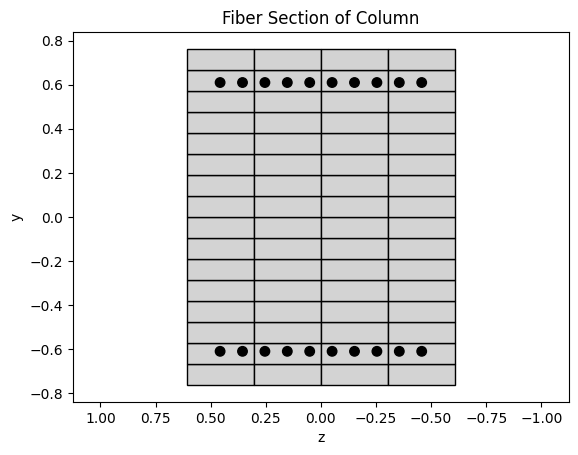

In [19]:
getModel()
getSections()
getRecorders('fiberSection', 'GravityAnalysis')
runGravityAnalysis()

In [14]:
getModel()

Text(0.5, 0.98, 'GravityAnalysis')

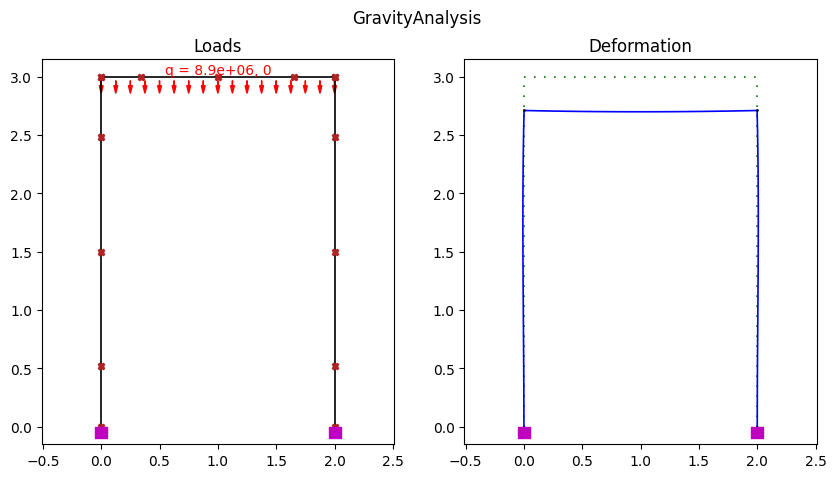

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ovs.plot_loads_2d(ax = ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Loads")
ax[1].set_title("Deformation")
plt.suptitle("GravityAnalysis")

#### Static Pushover

WARNING can't set handler after analysis is created
after: 100 iterations
 current EnergyIncr: 1530.91 (max: 1e-11) 	Norm deltaX: 0.000962455, Norm deltaR: 3.56273e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.95431
OpenSees > analyze failed, returned: -3 error flag


Analysis failed at load factor  52
Trying Newton with Initial Tangent at Load Factor 52


after: 100 iterations
 current EnergyIncr: 2.84974e-09 (max: 1e-11) 	Norm deltaX: 6.80073e-10, Norm deltaR: 8.48163
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.0172
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 4.16789e-07 (max: 1e-11) 	Norm deltaX: 8.182e-09, Norm deltaR: 103.151
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.06471
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 5.16098e-09 (max: 1e-11) 	Norm deltaX: 9.10386e-10, Norm deltaR: 11.4774
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.07437
OpenSees > analyze failed, retu

Analysis failed at load factor  65
Trying Newton with Initial Tangent at Load Factor 65
Analysis failed at load factor  75
Trying Newton with Initial Tangent at Load Factor 75
Analysis failed at load factor  77
Trying Newton with Initial Tangent at Load Factor 77


after: 100 iterations
 current EnergyIncr: 3.48891e-09 (max: 1e-11) 	Norm deltaX: 7.4868e-10, Norm deltaR: 9.43619
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.07927
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 3.88274e-09 (max: 1e-11) 	Norm deltaX: 7.87898e-10, Norm deltaR: 9.94566
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.08412
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 1.08399e-10 (max: 1e-11) 	Norm deltaX: 1.31633e-10, Norm deltaR: 1.66175
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.08883
OpenSees > analyze failed, re

Analysis failed at load factor  78
Trying Newton with Initial Tangent at Load Factor 78
Analysis failed at load factor  79
Trying Newton with Initial Tangent at Load Factor 79
Analysis failed at load factor  80
Trying Newton with Initial Tangent at Load Factor 80
Analysis failed at load factor  81
Trying Newton with Initial Tangent at Load Factor 81
Analysis failed at load factor  82
Trying Newton with Initial Tangent at Load Factor 82
Analysis failed at load factor  83
Trying Newton with Initial Tangent at Load Factor 83
Analysis failed at load factor  84
Trying Newton with Initial Tangent at Load Factor 84
Analysis failed at load factor  85
Trying Newton with Initial Tangent at Load Factor 85


after: 100 iterations
 current EnergyIncr: 6.18784e-10 (max: 1e-11) 	Norm deltaX: 3.19178e-10, Norm deltaR: 3.94904
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.13353
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 2.34341e-07 (max: 1e-11) 	Norm deltaX: 6.12128e-09, Norm deltaR: 78.1291
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.13803
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 0.000792069 (max: 1e-11) 	Norm deltaX: 3.72159e-07, Norm deltaR: 4372.14
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.11644
OpenSees > analyze failed, r

Analysis failed at load factor  90
Trying Newton with Initial Tangent at Load Factor 90
Analysis failed at load factor  91
Trying Newton with Initial Tangent at Load Factor 91
Analysis failed at load factor  92
Trying Newton with Initial Tangent at Load Factor 92


after: 100 iterations
 current EnergyIncr: 3.84315e-08 (max: 1e-11) 	Norm deltaX: 2.52265e-09, Norm deltaR: 31.0121
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.14913
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 5.38979e-10 (max: 1e-11) 	Norm deltaX: 2.98274e-10, Norm deltaR: 3.67614
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.15342
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 6.33428e-09 (max: 1e-11) 	Norm deltaX: 1.01816e-09, Norm deltaR: 12.5965
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.15704
OpenSees > analyze failed, r

Analysis failed at load factor  94
Trying Newton with Initial Tangent at Load Factor 94
Analysis failed at load factor  95
Trying Newton with Initial Tangent at Load Factor 95
Analysis failed at load factor  96
Trying Newton with Initial Tangent at Load Factor 96
Analysis failed at load factor  97
Trying Newton with Initial Tangent at Load Factor 97
Analysis failed at load factor  98
Trying Newton with Initial Tangent at Load Factor 98


after: 100 iterations
 current EnergyIncr: 1.46259e-09 (max: 1e-11) 	Norm deltaX: 4.90571e-10, Norm deltaR: 6.06135
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.16218
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 5.03452e-11 (max: 1e-11) 	Norm deltaX: 9.09861e-11, Norm deltaR: 1.12462
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.16375
OpenSees > analyze failed, returned: -3 error flag


Analysis failed at load factor  99
Trying Newton with Initial Tangent at Load Factor 99
Analysis failed at load factor  100
Trying Newton with Initial Tangent at Load Factor 100
Success! Pushover Analysis	 Node=3, Dof=1, Disp=0.30000300830993204


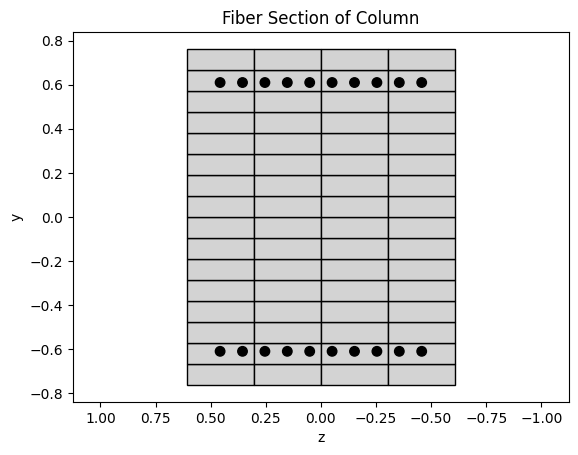

In [21]:
getModel()
getSections()
runGravityAnalysis()
getRecorders('fiberSection', 'StaticPushover')
runStaticPushover()

Text(0.5, 0.98, 'Static Pushover Analysis')

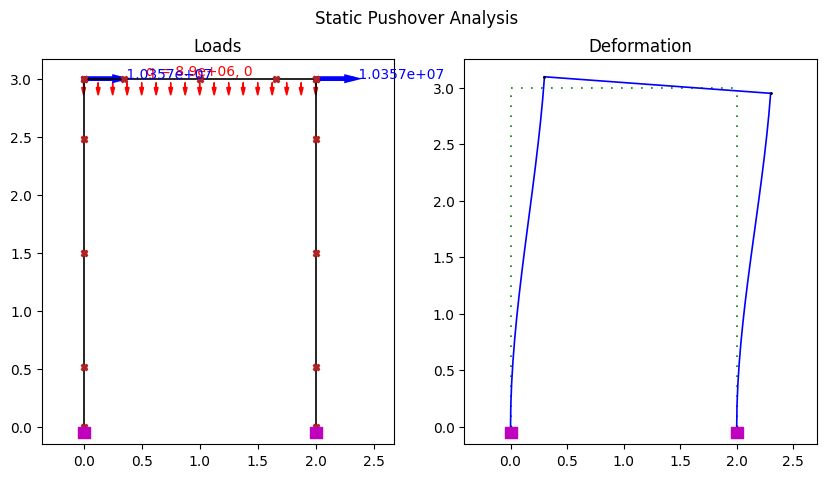

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ovs.plot_loads_2d(ax = ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Loads")
ax[1].set_title("Deformation")
plt.suptitle("Static Pushover Analysis")

Text(0.5, 1.0, 'Force Deformation Response - Static Pushover')

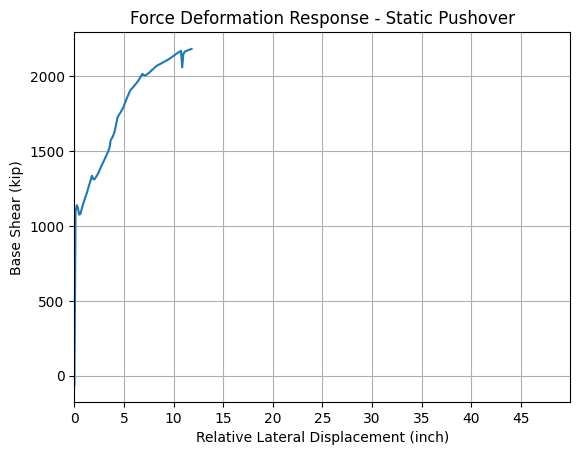

In [24]:
disps = np.loadtxt('Outputs/fiberSection/StaticPushover/DispFree.txt')
rxns = np.loadtxt('Outputs/fiberSection/StaticPushover/ReactionsSupport.txt')
plt.plot(disps[:, 1]/inch, -rxns[:,1]/kip)
plt.grid()
plt.xticks(list(range(0, 50, 5)))
plt.xlim((0, 50))
#plt.ylim((0, 800))
plt.xlabel("Relative Lateral Displacement (inch)")
plt.ylabel("Base Shear (kip)")
plt.title("Force Deformation Response - Static Pushover")

#### Reverse Cyclic Pushover

3 0.003
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


WARNING can't set handler after analysis is created
after: 100 iterations
 current EnergyIncr: 171.624 (max: 1e-11) 	Norm deltaX: 0.000324342, Norm deltaR: 1.28822e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.867673
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 178.239 (max: 1e-11) 	Norm deltaX: 0.000329577, Norm deltaR: 1.31592e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.868967
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 1(dW: << -0.858006)
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 2(dW: << 47.4123)
Domain::update - domain failed in update
DisplacementControl::update - model failed to update for new dU
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 3.07855
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 2(dW: << -0.136945)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at step: 0 with domain at load factor 0.905919
OpenSees > analyze failed, returned: -2 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 2(dW: << -0.136945)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at step: 0 with domain at load factor 0.905919
OpenSees > analyze failed, returned: -2 error flag
WARNING unknown algorithm type Bryoden
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 2(dW: << -0.136945)
Domain::update - domain failed in update
DisplacementControl::newStep - mod

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Trying Bryoden
Trying Newton with Line Search
Failed ! Terminating Analysis


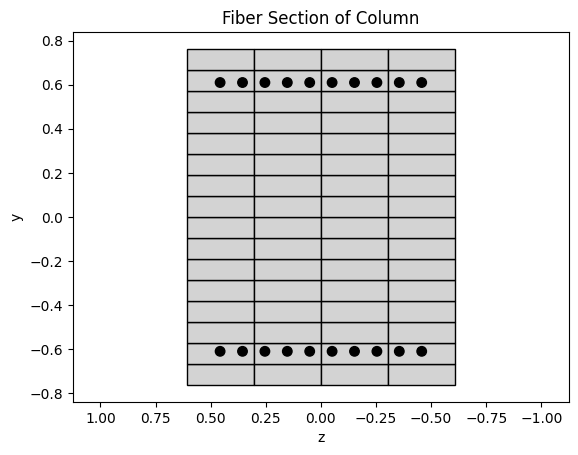

In [25]:
getModel()
getSections()
runGravityAnalysis()
getRecorders('fiberSection', 'CyclicPushover')
runReverseCyclicPushover(1)

Text(0.5, 0.98, 'Reverse Cyclic Pushover Analysis')

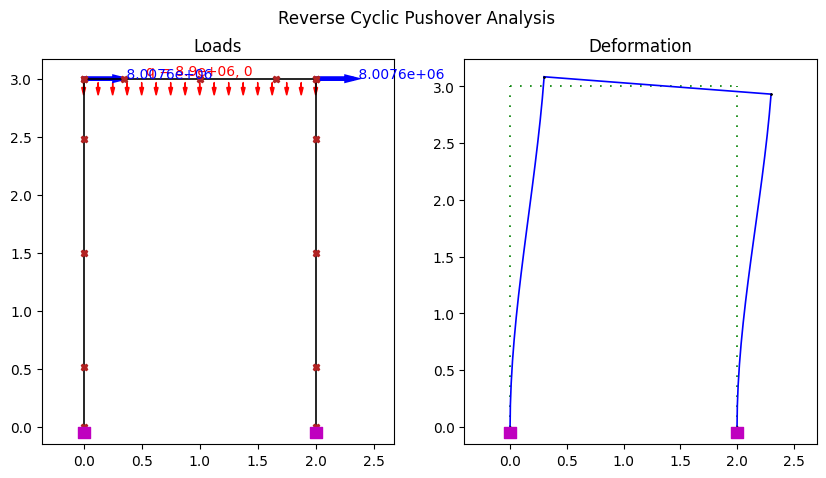

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ovs.plot_loads_2d(ax = ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Loads")
ax[1].set_title("Deformation")
plt.suptitle("Reverse Cyclic Pushover Analysis")

Text(0.5, 1.0, 'Force Deformation Response - Full Cycle Cyclic Pushover')

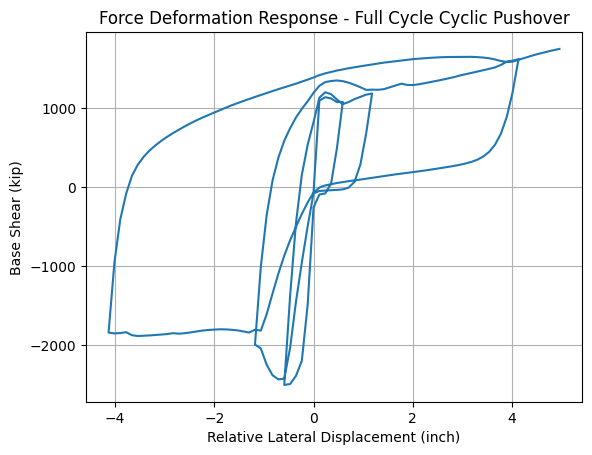

In [27]:
disps = np.loadtxt('Outputs/fiberSection/CyclicPushover/DispFree.txt')
rxns = np.loadtxt('Outputs/fiberSection/CyclicPushover/ReactionsSupport.txt')
plt.plot(disps[:, 1]/inch, -rxns[:,1]/kip)
plt.grid()
#plt.xticks(list(range(0, 50, 5)))
#plt.xlim((0, 50))
#plt.ylim((0, 800))
plt.xlabel("Relative Lateral Displacement (inch)")
plt.ylabel("Base Shear (kip)")
plt.title("Force Deformation Response - Full Cycle Cyclic Pushover")

#### runnning 3 cycles

3 0.003


WARNING can't set handler after analysis is created
after: 100 iterations
 current EnergyIncr: 421.882 (max: 1e-11) 	Norm deltaX: 0.000688233, Norm deltaR: 1.54432e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.842422
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 561.258 (max: 1e-11) 	Norm deltaX: 0.000656546, Norm deltaR: 2.14724e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.837362
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 359.258 (max: 1e-11) 	Norm deltaX: 0.000409147, Norm deltaR: 2.19926e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.776384
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 295.821 (max: 1e-11) 	Norm deltaX: 0.000907318, Norm deltaR: 1.27057e+06
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.78141
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 1(dW: << -6.30194)
Domain::update - domain failed in update
DisplacementControl::update - model failed to update for new dU
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.898862
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 6.73735 (max: 1e-11) 	Norm deltaX: 0.000224421, Norm deltaR: 69051
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.541846
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 0.843915 (max: 1e-11) 	Norm deltaX: 6.38343e-05, Norm deltaR: 31074.9
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.86435
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 9.38896 (max: 1e-11) 	Norm deltaX: 0.000105308, Norm deltaR: 241292
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.901605
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 1(dW: << -0.0294272)
Domain::update - domain failed in update
DisplacementControl::update - model failed to update for new dU
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.970333
OpenSees > analyze failed, returned: -3 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 1(dW: << -1.51311)
Domain::update - domain failed in update
DisplacementControl::update - model failed to update for new dU
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.970679
OpenSees > analyze failed, returned: -3 error flag
WARNING unknown algorithm type Bryoden
WARNING - ForceBeamColumn2d::update - failed to get

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Trying Bryoden
Trying Newton with Line Search
Failed ! Terminating Analysis


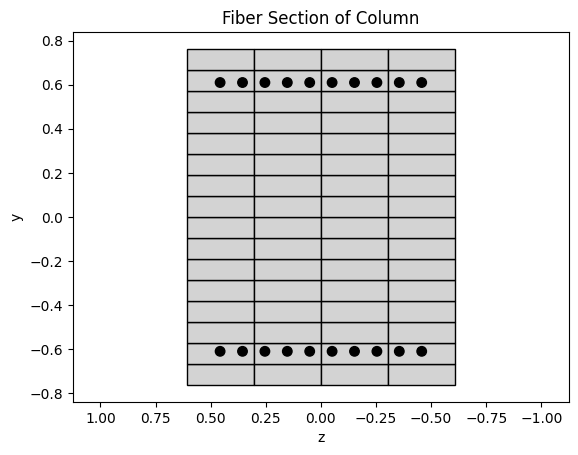

In [28]:
getModel()
getSections()
runGravityAnalysis()
getRecorders('fiberSection', 'CyclicPushover')
runReverseCyclicPushover(3)

Text(0.5, 1.0, 'Force Deformation Response - 3 Full Cycle Pushover')

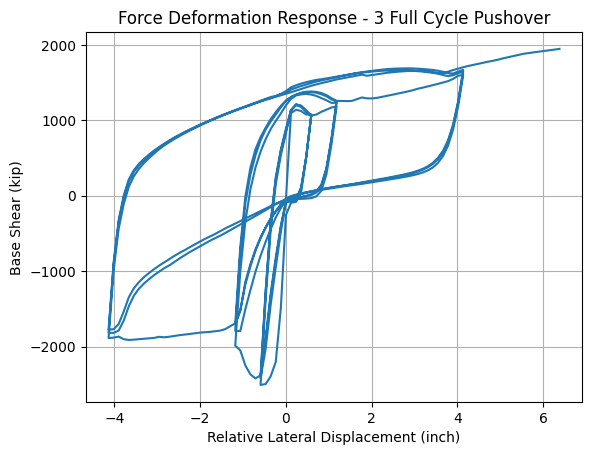

In [29]:

disps = np.loadtxt('Outputs/fiberSection/CyclicPushover/DispFree.txt')
rxns = np.loadtxt('Outputs/fiberSection/CyclicPushover/ReactionsSupport.txt')
plt.plot(disps[:, 1]/inch, -rxns[:,1]/kip)
plt.grid()
#plt.xticks(list(range(0, 50, 5)))
#plt.xlim((0, 50))
#plt.ylim((0, 800))
plt.xlabel("Relative Lateral Displacement (inch)")
plt.ylabel("Base Shear (kip)")
plt.title("Force Deformation Response - 3 Full Cycle Pushover")

# running half cycle only

In [70]:
getModel()
getSections(False)
runGravityAnalysis()
getRecorders('nonLinear', 'CyclicPushover')
runReverseCyclicPushover(1, 'Push')


10.972821945643894 0.010972821945643894


WARNING can't set handler after analysis is created
after: 100 iterations
 current EnergyIncr: 13.0591 (max: 1e-11) 	Norm deltaX: 0.000337793, Norm deltaR: 83192.5
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.292976
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 0.818912 (max: 1e-11) 	Norm deltaX: 6.01173e-05, Norm deltaR: 30438.8
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.300061
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 27.4073 (max: 1e-11) 	Norm deltaX: 0.000327886, Norm deltaR: 174229
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.300769
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 2.22052 (max: 1e-11) 	Norm deltaX: 0.000132421, Norm deltaR: 37076.7
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.303016
OpenSees > analyze failed, returned: 

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 5.85248 (max: 1e-11) 	Norm deltaX: 0.000160974, Norm deltaR: 79562.1
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.304853
OpenSees > analyze failed, returned: -3 error flag


Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 43.3071 (max: 1e-11) 	Norm deltaX: 0.000419213, Norm deltaR: 208610
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.299854
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 10.5604 (max: 1e-11) 	Norm deltaX: 0.000236021, Norm deltaR: 96019.3
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.29092
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 84.7682 (max: 1e-11) 	Norm deltaX: 0.000695998, Norm deltaR: 257352
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.288277
OpenSees > analyze failed, returned: -3 

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 30.4427 (max: 1e-11) 	Norm deltaX: 0.000225704, Norm deltaR: 281994
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.290833
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 86.8371 (max: 1e-11) 	Norm deltaX: 0.000709135, Norm deltaR: 258237
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.285665
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 6.30193 (max: 1e-11) 	Norm deltaX: 0.000229971, Norm deltaR: 55359.3
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.29307
OpenSees > analyze failed, returned: -3 

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 14.8755 (max: 1e-11) 	Norm deltaX: 0.000245873, Norm deltaR: 130177
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.297727
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 0.384035 (max: 1e-11) 	Norm deltaX: 3.6832e-05, Norm deltaR: 23655.3
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.298311
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 2.06382 (max: 1e-11) 	Norm deltaX: 0.000130619, Norm deltaR: 34397.7
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.299381
OpenSees > analyze failed, returned

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 1.01805 (max: 1e-11) 	Norm deltaX: 4.90757e-05, Norm deltaR: 45811.5
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.297506
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 110.905 (max: 1e-11) 	Norm deltaX: 0.000383857, Norm deltaR: 586057
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.292688
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 23.5413 (max: 1e-11) 	Norm deltaX: 0.00049542, Norm deltaR: 100037
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.293867
OpenSees > analyze failed, returned: 

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent


after: 100 iterations
 current EnergyIncr: 1.23567 (max: 1e-11) 	Norm deltaX: 7.6196e-05, Norm deltaR: 33692.3
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.282645
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 10.3473 (max: 1e-11) 	Norm deltaX: 0.000302727, Norm deltaR: 96458.9
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.276045
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 0.0779823 (max: 1e-11) 	Norm deltaX: 2.5186e-05, Norm deltaR: 6223.81
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -0.276494
OpenSees > analyze failed, returne

Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Analysis Failed ! Trying other methods ...
Trying Newton with Initial Tangent
Success! Cyclic Pushover Analysis	 Node=3, Dof=1, Disp=5.280861725990779e-05


after: 100 iterations
 current EnergyIncr: 0.028472 (max: 1e-11) 	Norm deltaX: 1.04764e-05, Norm deltaR: 5471.45
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.0871239
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 4.34768 (max: 1e-11) 	Norm deltaX: 0.000197368, Norm deltaR: 44764.5
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.118098
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations
 current EnergyIncr: 12.7886 (max: 1e-11) 	Norm deltaX: 0.000297266, Norm deltaR: 88097.7
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.118346
OpenSees > analyze failed, returned

Text(0.5, 1.0, 'Force Deformation Response - Full Cycle Cyclic Pushover')

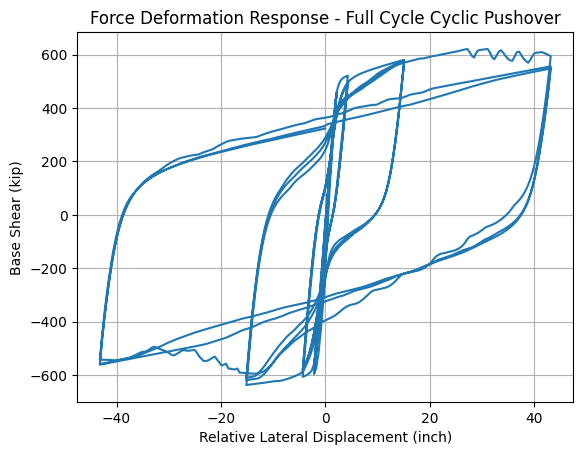

In [71]:
disps = np.loadtxt('Outputs/fiberSection/CyclicPushover/DispFree.txt')
rxns = np.loadtxt('Outputs/fiberSection/CyclicPushover/ReactionsSupport.txt')
plt.plot(disps[:, 1]/inch, -rxns[:,1]/kip)
plt.grid()
#plt.xticks(list(range(0, 50, 5)))
#plt.xlim((0, 50))
#plt.ylim((0, 800))
plt.xlabel("Relative Lateral Displacement (inch)")
plt.ylabel("Base Shear (kip)")
plt.title("Force Deformation Response - Full Cycle Cyclic Pushover")

In [15]:
ops.wipe()

In [16]:
ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)

In [17]:
LBeam = 2
LCol = 3
ops.node(1, 0, 0)
ops.node(2, LBeam, 0)
ops.node(3, 0, LCol)
ops.node(4, LBeam, LCol)

<Axes: >

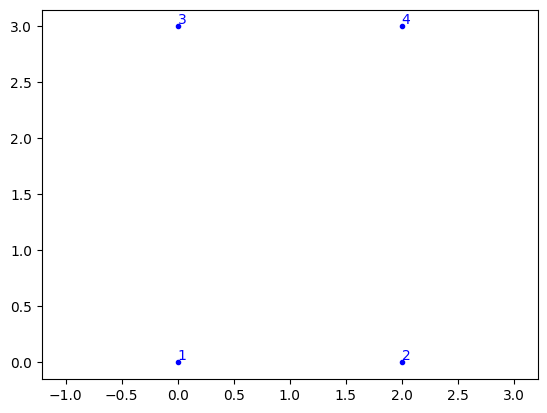

In [18]:
ovs.plot_model()